# Credible Threats

## Datalicious

### Importing Data

In [18]:
# Importing packages
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np
from ipywidgets import Layout
import seaborn as sns
import math
import requests
from bs4 import BeautifulSoup as bs
# import pyprind   ## Skal lige få dette til at virke!
sns.set()

In [2]:
filename = 'imdb.csv'

def gen_df(filename):

    # Get .csv.file
    data = pd.read_csv(filename, sep=';', encoding='latin-1', escapechar='\\')

    # Read file into pandas dataframe
    df = pd.DataFrame(data)

    # Drop unwanted columns
    for i in range(44,48):
        df.drop(columns=[f'Unnamed: {i}'], inplace=True)

    df.drop(columns=['fn','wordsInTitle','url'], inplace=True)

    # Keep only observations of movie-type
    I = df['type'] == 'video.movie'
    df = df.loc[I]
    df.drop(columns=['type'], inplace=True)

    # Drop observations with missing data
    df.dropna(inplace=True)

    # Replace 0's in imdb-ratings
    df['imdbRating'] = df['imdbRating'].astype(str)
    df['imdbRating'].replace(regex=True, inplace=True,to_replace='0',value='')
    df['imdbRating'] = df['imdbRating'].astype(float)

    # Transform duration from seconds to hours
    df['duration'] = df['duration']/60**2

    # Drop years before 1920 and 2014 because of few obervations
    I = (df['year']>=1920) & (df['year']<=2013)
    df = df.loc[I]

    # Change the type of 'year' to integer
    df['year'] = df['year'].astype(int)    
    
    # Sort observations and reset index
    df.sort_values('year', inplace=True)
    df.reset_index(inplace=True)


    # Generating variable that shows the decade (as a string)
    year_list = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

    df['decade'] = ''
    for i,start in enumerate(year_list):
        end = start+10
        df.loc[(df['year'] >= start) & (df['year'] < end), 'decade'] = f'{year_list[i]}s'

    return df

df = gen_df(filename)


### Descriptive Data

In [30]:
# Summary Statistics by Decade  
decade = ["all", "1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s"]

def summ_stat(decade):
    """ Generates a Summary Statistics Table 
    
    Args: 
        decade (string): Decade for which the summary statistics are generated. 
                         These must be written in the format, "[decade]s", e.g. "1920s".
        
    Returns: 
        One table for each element in decade. 
        
    Notice: The function is generated so that it can be called in the function summ_stat_interactive. Thus, it is not intended to be used on its own. 
    
    """
    
    
    pd.options.display.float_format = "{:.2f}".format
    if decade == "all": 
        return df[["year", "imdbRating", "duration", "nrOfWins", "nrOfNominations"]].describe() 
    else: 
        df_decade = df.loc[df["decade"] == decade]
        return df_decade[["year", "imdbRating", "duration", "nrOfWins", "nrOfNominations"]].describe() 
    

def summ_stat_interactive(): 
    
    """ Generates a interactive Summary Statistics Table, using the function summ_stat. """
    
    
    widgets.interact(summ_stat, 
    
    # Decade Dropdown 
    decade = widgets.Dropdown(
    decription="Decade", 
    options=decade, 
    value="all"));

summ_stat_interactive()


interactive(children=(Dropdown(description='decade', options=('all', '1920s', '1930s', '1940s', '1950s', '1960…

,year,imdbRating,duration,nrOfWins,nrOfNominations
count,154.00,154.00,154.00,154.00,154.00
mean,1925.62,7.56,1.46,0.34,0.12
std,2.81,0.66,0.54,0.71,0.54
min,1920.00,4.70,0.07,0.00,0.00
25%,1924.00,7.10,1.17,0.00,0.00
50%,1926.00,7.70,1.42,0.00,0.00
75%,1928.00,8.10,1.68,0.00,0.00
max,1929.00,8.40,4.00,3.00,4.00


In [8]:
# Defining function that rounds up to next hundred 
def roundup(x):
    """ Returns an integer which is perfectly divided by 100

        Args: 
            x (float): The number to round up to next hundred

        Returns: 
            A number (integer) """
    
    return int(math.ceil(x / 100.0)) * 100

## Defining a figure which plot the total numbers of movies per year or decade
def fig3_J():
    """ Generates a figure which plots the total number of movies per decade or year
    
    Args: 
        No arguments are needed.
        
    Returns: 
        An interactive plot  
        
    Notice: 
        It will raise an error if the function are given an argument!
    """
    
    ## Copiyng the dataframe to a new dataframe
    imdb = df.copy()
    
    ## Generating list for future use
    time_var = ['year', 'decade']
    decades = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]
    
    ## Defining function that plot the total numbers of movies per year or decade
    def fig(time_var):   
        """ Generates a figure which plots the total number of movies per decade or year
        
        Args: 
            time_var (string): Should be either 'year' or 'decade' depending on if the 
            number of movies should be grouped by on year or decade. 
           
        Returns: 
            An interactive plot.  

        Notice: 
            The function is generated so that it can be called using widgets.interact. 
            Thus, it is not intended to be used on its own. 
            """
        
        # Generate variable that counts number of observation/movies in each year/decade
        imdb['temp']=1
        imdb['tot_film'] = imdb.groupby(time_var)['temp'].transform(lambda x : x.sum())
        del imdb['temp']

        # Make new dataframe that only take one value per year/decade. 
        # The dataframe only contain the year/decade indicator and number of movies in the given year/decade
        y = pd.DataFrame(imdb.groupby(time_var)['tot_film'].first())
        y.reset_index(inplace=True)

        # Setting max value of y-axis to next hundred of max number of movies
        temp = imdb['tot_film'].max()
        y_max = roundup(temp)

        # Plotting the number of movies per year
        fig = plt.figure(figsize=(7,6))
        ax1 = fig.add_subplot(1,1,1)

        # Set different bar-width depending on the plot is movies per year or decade
        if time_var == 'year':
            ax1.bar(y[time_var], y['tot_film'], color='black', width=0.55)
        else:
            ax1.bar(y[time_var], y['tot_film'], color='black')

        ax1.set_ylabel('Numbers of movies')
        ax1.set_title(f'Numbers of movies, 1920-2013')
        ax1.set_ylim([0,y_max])

        # Set the ticks on the x-axis to be every 10th year (if the plots is movies per year)
        if time_var == 'year':            
            ax1.set_xticks(decades)
            
    ## Making the figure interactive so it is optionally to plot the number of movies per year or decade (year is default)
    widgets.interact(fig,
        time_var = widgets.Dropdown(description='Time unit', value='year', options=time_var, 
                    layout=Layout(width='175px')),
    );    

fig3_J()

interactive(children=(Dropdown(description='Time unit', layout=Layout(width='175px'), options=('year', 'decade…

## Staring into the Eyes of Genres

### Number of Movies in Each Genre

In [7]:
# Generating genre list
genre = list(df)[13:41]

# Counting movies in each genre
for i in genre: 
    sum = df[i].sum(axis=0)
    print(f'Number of {i} movies: {sum:.0f}')

Number of Action movies: 1772
Number of Adult movies: 16
Number of Adventure movies: 1456
Number of Animation movies: 534
Number of Biography movies: 541
Number of Comedy movies: 3327
Number of Crime movies: 1638
Number of Documentary movies: 778
Number of Drama movies: 5109
Number of Family movies: 685
Number of Fantasy movies: 679
Number of FilmNoir movies: 190
Number of GameShow movies: 2
Number of History movies: 460
Number of Horror movies: 935
Number of Music movies: 269
Number of Musical movies: 332
Number of Mystery movies: 750
Number of News movies: 2
Number of RealityTV movies: 2
Number of Romance movies: 1707
Number of SciFi movies: 731
Number of Short movies: 380
Number of Sport movies: 205
Number of TalkShow movies: 3
Number of Thriller movies: 1235
Number of War movies: 442
Number of Western movies: 292


### Share of movies pr. genre

In [6]:
# Generate genre list
genre_list = list(df)[13:41]

def genre_share_fig():

    def _plot_1(df,genre,timevar):

        df['count'] = 1
        df['movies_year'] = df.groupby(timevar)['count'].transform(lambda x: x.sum())  

        # Plot year sum of different genres
        for i in genre:
    
            # Calculate sum of movies by timevariable, and share of movies within time that is of a certain genre
            df[f'{i}_time'] = df.groupby(timevar)[i].transform(lambda x: x.sum())
            df[f'{i} share'] = df[f'{i}_time']/df['movies_year']

            # Take first element of each timevariable group
            y_share = df.groupby(timevar)[f'{i} share'].first()

            # Plot the first eleents
            y_share.plot(kind='line', sharex='col', sharey='row')


            # Add labels and title
            plt.xlabel(timevar)
            plt.ylabel('Share of movies')
            if len(genre) == 1:
                plt.title(i)
            if len(genre) > 1:
                plt.legend(loc='upper left')

        #plt.show()

    def plot_1(df):

        widgets.interact(_plot_1,
                        df = widgets.fixed(df),
                        genre = widgets.SelectMultiple(
                            options = genre_list,
                            description = 'Genres',
                            disabled = False),
                        timevar = widgets.Dropdown(
                        options = ['year', 'decade'],
                        description = 'Timevariable',
                        value = 'decade',
                        disabled = False))

    plot_1(df)

genre_share_fig()

## X-axis!

interactive(children=(SelectMultiple(description='Genres', options=('Action', 'Adult', 'Adventure', 'Animation…

### Correlation Between Genres

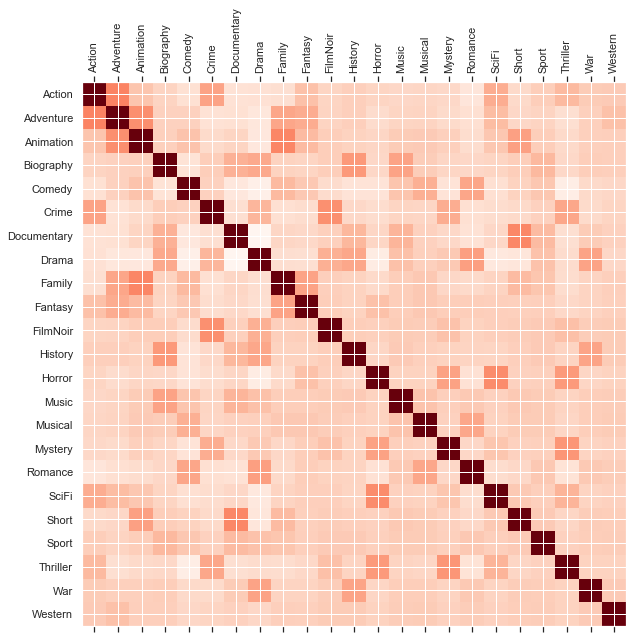

In [5]:
# New Genre List (Dropping Genres with less than 100 movies)
genre_new = ['Action', 'Adventure', 'Animation', 'Biography',
         'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
         'FilmNoir', 'History', 'Horror', 'Music', 'Musical',
         'Mystery', 'Romance', 'SciFi', 'Short', 'Sport', 'Thriller', 'War', 'Western']


# Heat map between genres
corr = df[genre_new].corr()
# print(corr)

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr, cmap=plt.cm.Reds)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns);

## Rated PG 13 - Parents Strongly Cautioned

### Histogram of Number of Movies pr. Rating

In [9]:
# Interactive Histogram
def histogram(variable, genre, bins_num):
    """ Generates histogram of variable per genre
    
    Args: 
        variable (string): Variable on the vertical axis
        genre (string): Only movies of this genre is considered
        bins_num (int): Number of bins in the histogram
    
    Notice: 
        Remember quotationmarks around variable 
        bins_num must be an integer, and does not accept floats
    
    """
    
    df_hist = df.loc[df[genre] == 1]
    plt.hist(df_hist[variable], bins=bins_num)
    
    # Labels
    plt.title("Number of Movies pr. Rating")
    plt.xlabel("Rating")
    plt.xticks(range(1,11))
    
# histogram("imdbRating", "Comedy", 10)   # Remember quote marks around variable names. 


def hist_interactive(variable="imdbRating"): 
    """ Generate interactive histogram of variable by genre
    
    Args: 
        variable (string): Variable on the vertical axis.
        
    Default variable = "imdbRating"
    
    """
    
    
    widgets.interact(histogram, 
    variable = widgets.fixed(variable), 
    
    # Genre Dropdown
    genre = widgets.Dropdown(
    description="Genre", 
    options=genre, 
    value="Comedy"),
    
    # Bins slider 
    bins_num=widgets.IntSlider(
    value=10,
    description="Bins", 
    min=1,
    max=50, 
    step=1,
    disabled=False,
    continuous_update=False)
    ); 

hist_interactive()

## Skulle den laves som andele i stedet for antal?? Og rykkes op til genre

interactive(children=(Dropdown(description='Genre', index=5, options=('Action', 'Adult', 'Adventure', 'Animati…

### Ratings over time

In [10]:
## Defining function which plots the average IMDB rating per year or decade
def fig2_J():
    """ Generates a figure which plots the average IMDB rating (in levels and normalized) per year or decade
    
    Args: 
        No arguments are needed.
        
    Returns: 
        Two interactive plots
        
    Notice: 
        It will raise an error if the function are given an argument!
    """    
    
    ## Copiyng the dataframe to a new dataframe
    imdb = df.copy()
    
    ## Generating list for future use
    time_var = ['year', 'decade']
    decades = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]
    
    
    ## Defining function that plots the average IMDB rating (in levels and normalized) per year or decade
    def fig(time_var):    
        """ Generates a figure which plots the average IMDB 
        rating (in levels and normalized) per year or decade
        
        Args: 
            time_var (string): Should be either 'year' or 'decade' depending on if the 
            average ratings should be grouped by on year or decade. 
           
        Returns: 
            Two interactive plot.  

        Notice: 
            The function is generated so that it can be called using widgets.interact. 
            Thus, it is not intended to be used on its own. 
            """        
        # Creating variable that takes the average IMDB rating per year/decade
        imdb['avg_rat'] = imdb.groupby(time_var)['imdbRating'].transform(lambda x : x.mean())
        imdb['avg_rat_index'] = imdb['avg_rat'].transform(lambda x : x/x[0]*100)
        
        # Make two new dataframes that only take one value per year/decade. 
        # The dataframes only contain the year/decade indicator and average rating or normalized ratings per year/decade
        y = pd.DataFrame(imdb.groupby(time_var)['avg_rat'].first())
        y.reset_index(inplace=True)
        
        x = pd.DataFrame(imdb.groupby(time_var)['avg_rat_index'].first())
        x.reset_index(inplace=True)

        # Plotting the figures
        fig = plt.figure(figsize=(13,6))
        
        # 1st Figure (ratings in level)
        ax1 = fig.add_subplot(1,2,1)
        ax1.plot(y[time_var], y['avg_rat'], color='black')
        ax1.set_ylabel('Average rating')
        ax1.set_title(f'Average IMDB rating, 1920-2013')
        ax1.set_ylim([0,10])

        #2nd Figure (normalized ratings)
        ax2 = fig.add_subplot(1,2,2)
        ax2.plot(x[time_var], x['avg_rat_index'], color='black')
        if time_var == 'year':
            ax2.set_ylabel(f'Index: 1920=100')
        else:
            ax2.set_ylabel(f'Index: 1920s=100')
        ax2.set_title(f'Normalized average of IMDB rating, 1920-2013')
        ax2.set_ylim([80,105])
        
        # Set the ticks on the x-axis to be every 10th year (if the plots is movies per year)
        if time_var == 'year':            
            ax1.set_xticks(decades)            
            ax2.set_xticks(decades)
            
    ## Making the figure interactive so it is optionally to plot the ratings per year or decade (year is default)                    
    widgets.interact(fig,
        time_var = widgets.Dropdown(description='Time unit', value='year', options=time_var, 
                    layout=Layout(width='175px')),
    );    

fig2_J()

interactive(children=(Dropdown(description='Time unit', layout=Layout(width='175px'), options=('year', 'decade…

### Do good movies have better ratings?

In [12]:
## Defining a function which plots the distribution of the IMDB rating conditioned on award wins
def fig1_J():
    """ Generates a figure which plots the distribution of the IMDB rating conditioned on award wins
    
    Args: 
        No arguments are needed.
        
    Returns: 
        An interactive plots
        
    Notice: 
        It will raise an error if the function are given an argument!
    """   
    
    ## Copiyng the dataframe to a new dataframe
    imdb = df.copy()
    
    ## Creating variable that groups number of wins and a list with the intervals
    imdb['nrw'] = 0
    imdb.loc[(imdb['nrOfWins'] > 0) & (imdb['nrOfWins'] < 10), ['nrw']] = 1
    imdb.loc[(imdb['nrOfWins'] >= 10) & (imdb['nrOfWins'] < 20), ['nrw']] = 2
    imdb.loc[(imdb['nrOfWins'] >= 20) & (imdb['nrOfWins'] < 30), ['nrw']] = 3
    imdb.loc[(imdb['nrOfWins'] >= 30) & (imdb['nrOfWins'] < 40), ['nrw']] = 4
    imdb.loc[(imdb['nrOfWins'] >= 40), ['nrw']] = 5
    
    nrwins = ['0', '1-10', '11-20', '21-30', '31-40', '+40']

    
    ## Defining a function to plot the distribution of the IMDB rating condition on award wins
    def fig(win_0, win_110, win_1120, win_2130, win_3140, win_40):
        """ Generates a figure which plots which plots the 
        distribution of the IMDB rating conditioned on award wins
        
        Args: 
            win_0: Specifies whether to plot the distribution of ratings for movies with 0 wins 
            win_110: Specifies whether to plot the distribution of ratings for movies with 1-10 wins 
            win_1120: Specifies whether to plot the distribution of ratings for movies with 11-20 wins 
            win_2130: Specifies whether to plot the distribution of ratings for movies with 21-30 wins 
            win_3140: Specifies whether to plot the distribution of ratings for movies with 31-40 wins 
            win_40: Specifies whether to plot the distribution of ratings for movies with +40 wins 
           
        Returns: 
            An interactive plot.  

        Notice: 
            The function is generated so that it can be called using widgets.interact. 
            Thus, it is not intended to be used on its own. 
            """         
        
        # Make lists to plot the win categories and give them colors
        wins = [win_0, win_110, win_1120, win_2130, win_3140, win_40]
        color = ['red', 'orange', 'yellow', 'lime', 'blue', 'purple']
        
        # Loop over win category to plot the distribution of their ratings
        for i,val in enumerate(nrwins):
            nrwins_i = imdb.loc[(imdb['nrw'] == i)]
            if wins[i] == True:  # Only plot distribution if box is 'checked'
                sns.distplot(nrwins_i['imdbRating'], hist = False, kde = True,
                         kde_kws = {'linewidth': 2}, label = val, color=color[i]
                     )
        
        # Legends and labels        
        plt.legend(loc='upper left')
        plt.title('IMDB rating conditioned on numbers of award wins')
        plt.xlabel('IMDB rating')
        plt.ylabel('Density')
    
    # Making the figure interactive so it is optinally which wins categories to plot
    widgets.interact(fig,
        win_0=widgets.Checkbox(description=nrwins[0], value=True, disabled=False),
        win_110=widgets.Checkbox(description=nrwins[1], value=True, disabled=False),
        win_1120=widgets.Checkbox(description=nrwins[2], value=True, disabled=False),
        win_2130=widgets.Checkbox(description=nrwins[3], value=True, disabled=False),
        win_3140=widgets.Checkbox(description=nrwins[4], value=True, disabled=False),
        win_40=widgets.Checkbox(description=nrwins[5], value=True, disabled=False),
    );

fig1_J()

interactive(children=(Checkbox(value=True, description='0'), Checkbox(value=True, description='1-10'), Checkbo…

### Do we have a selection problem?

In [13]:
## Defining function that creates a plot of the total number of 
## movies and award wins per decade as well as the number of award wins 
## normalized by the total award win in the decade
def fig4_J():
      
    """ Generates a two figures: a plot of the average number of 
    award wins normalized by the total award wins in the decade and
    a plot of the total award wins and total numbers of movies per decade. 
    
    Args: 
        No arguments are needed.
        
    Returns: 
        Two plots. One of them are interactive.  
        
    Notice: 
        It will raise an error if you give the function an argument!
    """
    
    
    ## Copiyng the dataframe to a new dataframe
    imdb = df.copy()
    
    ## Making variable that shows total numbers of award win per decade
    imdb['nrOfWins_tot'] = imdb.groupby('decade')['nrOfWins'].transform(lambda x : x.sum())
    
    ## Generating variable that take a movies share of total win in the decade
    imdb['nrOfWins_share'] = imdb['nrOfWins']/imdb['nrOfWins_tot']*100
    
    ## Taking the mean/median/P75 on the win share in each decade
    imdb['nrOfWins_share_avg'] = imdb.groupby('decade')['nrOfWins_share'].transform(lambda x: x.mean())
    imdb['nrOfWins_share_med'] = imdb.groupby('decade')['nrOfWins_share'].transform(lambda x: x.median())
    imdb['nrOfWins_share_p75'] = imdb.groupby('decade')['nrOfWins_share'].transform(lambda x: np.percentile(x,75))


    ## Generate variable that counts number of observation/movies in each decade
    imdb['temp']=1
    imdb['tot_film'] = imdb.groupby('decade')['temp'].transform(lambda x : x.sum())
    del imdb['temp']

    ## Creating a new dataframe that have one observation per decade
    y = pd.DataFrame(imdb.groupby('decade')['nrOfWins_tot'].first())
    y['nrOfWins_share_avg'] = imdb.groupby('decade')['nrOfWins_share_avg'].first()
    y['nrOfWins_share_med'] = imdb.groupby('decade')['nrOfWins_share_med'].first()
    y['nrOfWins_share_p75'] = imdb.groupby('decade')['nrOfWins_share_p75'].first()
    y['tot_film'] = imdb.groupby('decade')['tot_film'].first()
    y.reset_index(inplace=True)

    ## Plotting the total numbers of wins and movies and the average share of wins per decade
    def fig(median, p75):
        
        """ Generates the two figures: a plot of the average number of 
        award wins normalized by the total award wins in the decade and
        a plot of the total award wins and total numbers of movies per decade. 

        Args: 
            median: median == True means that the median award win per decade 
            (normalized by the total award win in the decade) is depicted
            
            p75: p75 == True means that the 75th percentile of the award win per decade 
            (normalized by the total award win in the decade) is depicted

        Returns: 
            Two plots. One of them are interactive.  

        Notice: 
            The function is generated so that it can be called using widgets.interact. 
            Thus, it is not intended to be used on its own. 
            """
        
        fig = plt.figure(figsize=(14,6))

        # 1st Figure
        ax1 = fig.add_subplot(1,2,1)
        ax1.plot(y['decade'], y['nrOfWins_share_avg'], color='blue', label='Average share of wins')
        if median == True:
            ax1.plot(y['decade'], y['nrOfWins_share_med'], color='blue', label='Median share of wins', linestyle='dashed')
        if p75 == True:
            ax1.plot(y['decade'], y['nrOfWins_share_p75'], color='blue', label='P75 share of wins', linestyle='dotted')
        ax1.set_ylim([0,0.7])
        ax1.legend(loc='upper right');
        ax1.set_ylabel('Share of total award wins in the decade, pct.')
        ax1.set_title(f'Average numbers of award wins normalized by total award wins')        
        
        # 2nd Figure
        ax2 = fig.add_subplot(1,2,2)
        ax2.plot(y['decade'], y['tot_film'], color='blue', label='Number of movies')
        ax2.plot(y['decade'], y['nrOfWins_tot'], color='black', label='Numbers of award wins')
        ax2.legend(loc='upper left');
        ax2.set_ylabel('Numbers of movies/award wins')
        ax2.set_title(f'Numbers of movies and award wins by decade, 1920-2013')

    
        # Making the figure interactive so the median and the 75th percentile is optionally
    widgets.interact(fig,
        median=widgets.Checkbox(description='Median', value=True, disabled=False),
        p75=widgets.Checkbox(description='P75', value=True, disabled=False),
    );
fig4_J()

interactive(children=(Checkbox(value=True, description='Median'), Checkbox(value=True, description='P75'), Out…

### Swarm Plot of Ratings pr. Decade

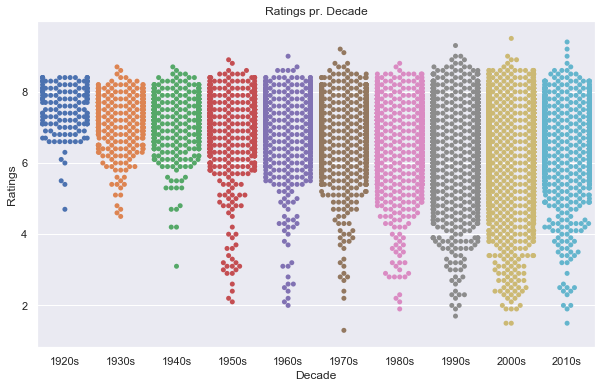

In [3]:
## NB: This peice of code takes a while to run!

# Swarm plot (Consider comparing decades) 
def swarm_plot(y="imdbRating"): 
    """ Creates a Swarm plot of y by decade
    
    Args:
    
        y (string): Variable on vertical axis. 
        
    Default: y = "imdbRating"
    Remember quotation marks around y. 
    
    """
    
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(1,1,1)
    ax1 = sns.swarmplot(x = "decade", y = y, data=df)
    if y == "imdbRating": 
        ax1.set_title("Ratings pr. Decade")
        ax1.set_ylabel("Ratings")
    elif y == "nrOfWins": 
        ax1.set_title("Wins pr. Decade")
        ax1.set_ylabel("Nr. of Wins")
    elif y == "nrOfNominations": 
        ax1.set_title("Nominations pr. Decade")
        ax1.set_ylabel("Nr. of Nominations")
    elif y == "duration": 
        ax1.set_title("Duration pr. Decade")
        ax1.set_ylabel("Duration")
    else: 
        ax1.set_title(f"{y} pr. Decade")
        ax1.set_ylabel(y)
    ax1.set_xlabel("Decade")
    

swarm_plot()

### Best and worst movies of each decade

This piece of code finds the original titles of the movies, by accesing the IMDb-webpage. This is done by using a library called "requests", and takes a little while to run, since it has to get titles for 100 movies.

In [14]:
# Defining a function to get original movie-titles
def find_orgnames():

    # Condition on minimum number of ratings
    I = df['ratingCount'] >= 5000

    # Sort top and bottom movies by decade
    top = df[I].reset_index(drop=True)
    top = top.sort_values(['decade', 'imdbRating'], ascending=False)
    top5_decade = top.groupby('decade').head(5)
    bottom = df[I].reset_index(drop=True)
    bottom = bottom.sort_values(['decade', 'imdbRating'], ascending=True)
    bottom5_decade = bottom.groupby('decade').head(5)

    # Get IMDb id's
    top5_id = top5_decade.tid.tolist()
    bottom5_id = bottom5_decade.tid.tolist()
    id5_list = top5_id + bottom5_id 

    # Initiate list to get names from IMDb
    org_names = []

    # Get original names from IMDb using requests
    for i,id in enumerate(id5_list):
        test = requests.get('https://www.imdb.com/title/' + id)
        soup = bs(test.text,'html.parser')
        if soup.find('div',class_='originalTitle') != None:
            org_names.append(soup.find('div',class_='originalTitle').text)
        else:
            org_names.append(soup.find('h1').text)
        perc.update()
            
    return (org_names, id5_list)

# For progressbar of getting movie titles
perc = pyprind.ProgPercent(100,monitor=True)

print('Accessing IMDb for original names')
(org_names, id5_list) = find_orgnames()

NameError: name 'pyprind' is not defined

In [17]:


# Function for creating list of top/bottom movies of each decade
def top_bottom_list(org_names, id5_list, decade):
    
    # Merge original names with data
    df_merge_1 = pd.DataFrame(i for i in org_names) # Names
    df_merge_2 = pd.DataFrame(i for i in id5_list) # ID
    df_merge = df_merge_1.merge(df_merge_2, left_index=True, right_index=True) # Set names and ID together
    df_merge = df_merge.rename(columns={'0_x': 'org_title', '0_y': 'tid'}) # Rename for merge

    text = ''

    # Merge with data
    top_bottom = df.merge(df_merge, how='inner', on='tid')
    top_bottom['org_title'] = top_bottom['org_title'].str.split('\(').str[0] # Remove parenthesis with years
    grouped = top_bottom[['org_title','imdbRating','decade']].sort_values('imdbRating', ascending=False).reset_index(drop=True).groupby('decade')

    # Prints solution
    for name, group in grouped:
        if name == decade:
            text += '\n\n'
            text += f'The top 5 movies of the {name} are: '
            name_list = group.org_title.tolist()
            rating_list = group.imdbRating.tolist()
            for j,i in enumerate(name_list):
                if j < 5:
                    text += '\n'
                    text += f'{i:<40} with rating: {rating_list[j]}'
                if j == 5:
                    text += '\n\n'
                    text += f'The bottom 5 movies of the {name} are: \n'
                    text += f'{i:<40} with rating: {rating_list[j]}'
                if j > 5:
                    text += '\n'
                    text += f'{i:<40} with rating: {rating_list[j]}'   

    print(text)
    
decades = list(df.decade.unique())
    
widgets.interact(top_bottom_list,
            decade = widgets.Dropdown(
                options = decades,
                description = 'Decade',
                value = '2010s'),
            org_names = widgets.fixed(org_names),
            id5_list = widgets.fixed(id5_list));
        

NameError: name 'org_names' is not defined

### What about the news?

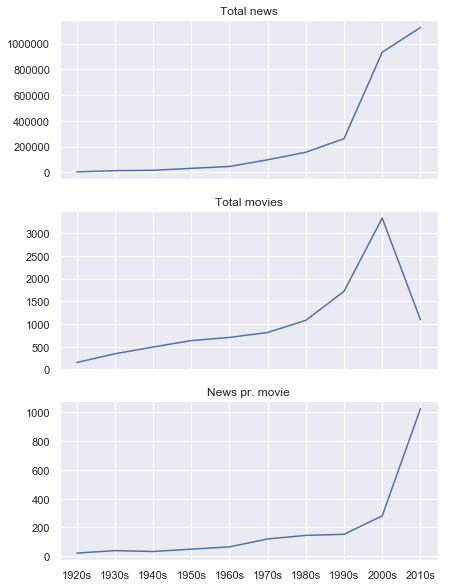

In [41]:
def news_pr_movie_fig():

    df['dummy'] = 1

    # Count number of news articles
    def total_news(x):
        d = x['nrOfNewsArticles'].sum()
        return pd.Series(d, index = ['Total number of news'])

    # Count number of movies
    def total_movies(x):
        d = x['dummy'].sum()
        return pd.Series(d, index = ['Total number of movies'])

    # Find news pr. movie
    def news_pr_movie(x):
        d = np.array(x['nrOfNewsArticles'].sum()/x['dummy'].sum())
        return pd.Series(d, index = ['news Pr Movie'])

    # Variables for plots
    x = df.groupby('decade').apply(total_news)
    z = df.groupby('decade').apply(news_pr_movie)
    y = df.groupby('decade').apply(total_movies)

    # Start subplot
    f, (fig1,fig2,fig3) = plt.subplots(3,1,sharex=True)
    f.subplots_adjust(hspace=0.2,right=1,top=2)

    # Plot the data
    fig1.plot(x)
    fig1.set_title('Total news')
    fig2.plot(y)
    fig2.set_title('Total movies')
    fig3.plot(z)
    fig3.set_title('News pr. movie');

news_pr_movie_fig()

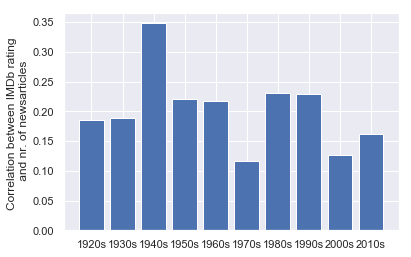

In [14]:
def corr_pr_decade():
    
    decade_list = []
    corr_list = []
    
    for i in df.decade.unique():
    
        I = df['decade'] == i
        df_temp = df[I]
        
        decade_list.append(i)
        corr_list.append(round(df_temp[['imdbRating','nrOfNewsArticles']].corr().iloc[0,1],3))
        
    plt.bar(decade_list,corr_list)
    plt.ylabel('Correlation between IMDb rating \n and nr. of newsarticles')
    
corr_pr_decade()